TOLERANCIA =  5e-08
pas 1  error =  0.49292804150259606
pas 2  error =  0.1871440735474537
pas 3  error =  0.07243464940693219
pas 4  error =  0.028943683280283086
pas 5  error =  0.016161256344645034
pas 6  error =  0.008233143676306356
pas 7  error =  0.004393931167133765
pas 8  error =  0.0026896183018170878
pas 9  error =  0.0014446334083944028
pas 10  error =  0.0007959684834898026
pas 11  error =  0.0004574866570794008
pas 12  error =  0.0002642393097520317
pas 13  error =  0.00015599910171945952
pas 14  error =  0.00010117540361377422
pas 15  error =  6.403802854054588e-05
pas 16  error =  3.923106502174911e-05
pas 17  error =  2.389493398884622e-05
pas 18  error =  1.4300688978484935e-05
pas 19  error =  8.571230839088296e-06
pas 20  error =  5.090374809875841e-06
pas 21  error =  3.0486817237156005e-06
pas 22  error =  1.8119244029612784e-06
pas 23  error =  1.0841720496397122e-06
pas 24  error =  6.469347182702e-07
pas 25  error =  3.857937363318014e-07
pas 26  error =  2.322

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.


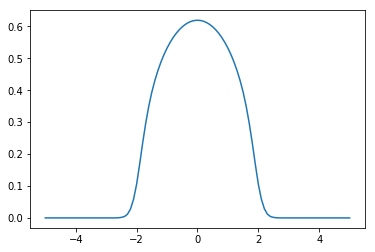

In [8]:
######### BESP 1D #########

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy.optimize
import scipy.sparse.linalg
from scipy.fftpack import fft, ifft
from krypy.linsys import LinearSystem, Gmres

np.set_printoptions(precision=8) # fer que numpy nomes faci print de 3 digits significatius
pi = np.pi

############ Dades input ############

# J ha de ser parell
J = 100 # punts eix X

lx = 10 # llargada eix X

beta = 500
sigma = 0.0 # Velocitat angular
dt = 0.05 # pas numèric
eps = 1e-6 # Marge d'error càlcul numèric
itmax = 10000 #nombre màxim iteracions



POTENCIAL = 0 #0 - Harmònic

# paràmetres potencial harmònic
gammax = 10

############ Auxiliars ############

dim1 = J
dim3 = J+1
dx = lx/(J) 
ax = lx/2
xj = np.arange(-ax,ax+dx,dx)
jj = np.arange(-J/2,J/2)
mux = pi*jj/lx

a = np.arange(0,J)
d = a[:,np.newaxis]


# Càlcul Laplaciana

D = np.zeros((dim3,dim3),dtype = 'complex')

for j1 in range(0,J+1): #dx2
    for j2 in range(1,J):
        aux = 1/J*sum(-mux**2*np.exp(mux*1j*(xj[j1]-xj[j2])))
        D[j1, j2] +=  aux

# Càlcul matriu moment angular
        
LZ = np.zeros((dim3,dim3),dtype = 'complex')

for j1 in range(0,J+1): #X
    for j2 in range(0,J+1):
        aux = -1j*xj[j1]*1/J*sum(mux*np.exp(mux*1j*(xj[j1]-xj[j2])))
        LZ[j1, j2] +=  aux

#Càlcul Potencial i funcio d'ona inicial
    
V = np.zeros((J+1))
phi0 = np.zeros((J+1),dtype='complex')

if POTENCIAL == 0: # Potencial Harmonic
    
    for j in range(0,J+1):
        V[j] = 1/2*(gammax**2*xj[j]**2)
        aux = np.exp(-(gammax*xj[j]**2)/2)
        phi0[j] = (gammax)**(1/4)/np.sqrt(pi)*aux

        
############ Funcions ############
        

def A_matrix(phi_old): #Retorna A donada una funció d'ona (1D array) phi_old
    #A = np.zeros(dim3,dim3)
    Id = np.identity(dim3)
    phi = Id*(phi_old**2)
    A = 1/dt*Id + Id*V + beta*phi -1/2*D-sigma*LZ
    return A

def b_vector(phi_old): #Retorna b donada una funció d'ona (1D array) phi_old
    #b = np.zeros(dim3)
    b = phi_old/dt
    return b
    


def krylov(A,b): #Resol sistema lineal amb mètode de Krylov
    
    solucio = scipy.sparse.linalg.lgmres(A,b)

    return solucio

print('TOLERANCIA = ', eps*dt)

def main(A0,b0,tol,it): #Aplica esquema iteratiu BESP criteri error phi2
    error = 2*tol
    numit = 0
    phi_new = phi0

    while((error>tol) and (numit<it)):
        phi_old = phi_new
        A_new = A_matrix(phi_old)
        b_new = b_vector(phi_old)
        phi_new = krylov(A_new,b_new)
        phi_new = np.array(phi_new[0])

        norma = (dx**0.5)*((sum(phi_new*np.conj(phi_new)))**0.5)
        norma = np.real(norma)
        phi_new = phi_new/norma
        error = max(np.abs(phi_old-phi_new)**2)
        numit += 1
        print('pas', numit , ' error = ', error)
        
    sol = phi_new

    return sol

def energia():
    A,b = Ab()
    E = 0
    return E

    

############ Execució programa ############


A_init = A_matrix(phi0)

b_init = b_vector(phi0)


tolerancia = eps*dt

sol_final = main(A_init,b_init,tolerancia,itmax)
sol_norma = (np.real(sol_final*np.conjugate(sol_final)))**0.5
#sol_norma = sol_norma.reshape((J+1,K+1,L+1),order='F')
sol_fase = (np.angle(sol_final))
#sol_fase = sol_fase.reshape((J+1,K+1,L+1),order='F')

#print('-------------- SOLUCIO = ', sol_norma)


############ Plots ############

#Calcul Grid
gridx = np.zeros((J+1))

for idx,elementx in enumerate(xj):
    gridx[idx] = elementx
        

fig, ax = plt.subplots()
ax.plot(gridx, sol_norma)
plt.show()

